In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Fri Jun 24 00:06:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 46%   50C    P8    22W / 260W |   3450MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 28%   

# LDA

## 2012 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2012.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(7097 unique tokens: ['一种', '亮氨酸', '代谢', '免疫性', '包括']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 2), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.418717,1666.892684
1,3,-7.378557,1601.278133
2,4,-7.337497,1536.860187
3,5,-7.332719,1529.534429
4,6,-7.318884,1508.520191
5,7,-7.306223,1489.540484
6,8,-7.296019,1474.417846
7,9,-7.273711,1441.891132
8,10,-7.253654,1413.259892
9,11,-7.239275,1393.083049


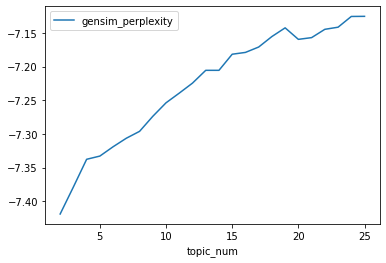

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.418717,1666.892684
1,3,-7.378557,1601.278133
2,4,-7.337497,1536.860187
3,5,-7.332719,1529.534429
4,6,-7.318884,1508.520191
5,7,-7.306223,1489.540484
6,8,-7.296019,1474.417846
7,9,-7.273711,1441.891132
8,10,-7.253654,1413.259892
9,11,-7.239275,1393.083049


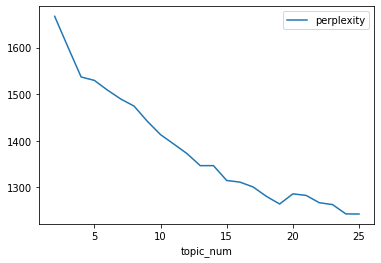

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2012.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

8

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[8,
 14,
 14,
 15,
 3,
 20,
 4,
 14,
 1,
 4,
 15,
 13,
 11,
 14,
 12,
 4,
 10,
 11,
 18,
 12,
 24,
 16,
 0,
 14,
 9,
 21,
 2,
 18,
 11,
 23,
 9,
 11,
 16,
 10,
 11,
 14,
 19,
 12,
 20,
 1,
 17,
 3,
 19,
 5,
 19,
 19,
 5,
 3,
 14,
 18,
 20,
 16,
 16,
 16,
 20,
 20,
 17,
 18,
 1,
 24,
 23,
 13,
 1,
 18,
 21,
 12,
 14,
 19,
 1,
 20,
 23,
 18,
 24,
 4,
 20,
 5,
 11,
 1,
 9,
 10,
 9,
 5,
 3,
 11,
 10,
 14,
 0,
 16,
 13,
 22,
 14,
 11,
 8,
 4,
 4,
 20,
 3,
 22,
 14,
 15,
 22,
 16,
 17,
 17,
 22,
 3,
 17,
 13,
 8,
 4,
 11,
 13,
 18,
 13,
 4,
 4,
 2,
 13,
 24,
 23,
 24,
 13,
 24,
 10,
 4,
 15,
 13,
 13,
 13,
 13,
 13,
 13,
 16,
 13,
 8,
 13,
 12,
 13,
 10,
 23,
 13,
 5,
 13,
 13,
 10,
 10,
 13,
 23,
 12,
 12,
 13,
 13,
 23,
 4,
 17,
 12,
 23,
 16,
 10,
 20,
 20,
 23,
 23,
 18,
 11,
 1,
 12,
 23,
 11,
 20,
 1,
 8,
 20,
 14,
 21,
 23,
 20,
 2,
 8,
 10,
 13,
 13,
 21,
 21,
 10,
 8,
 10,
 23,
 17,
 9,
 10,
 8,
 10,
 21,
 4,
 19,
 16,
 12,
 4,
 13,
 4,
 8,
 10,
 13,
 13,
 16,
 20,
 13,
 4,
 1,
 1,


In [25]:
print(len(topics_cn))
print(len(cn_desc))

852
852


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2012 = db.rm_patent_us_2012
    db_rm_cn_2012 = db.rm_patent_cn_2012
    # db_rm_de_2012 = db.rm_patent_de_2012
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2012.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61fd25e1f4d57576a5021669,CN103492389B,[Origenis GmbH],本发明涉及式(I)的新化合物，其能够抑制一种或多种激酶，尤其抑制SYK(脾酪氨酸激酶)、LR...
1,61fd26c2f4d57576a502166f,CN103958612B,[Toray Industries Inc],本发明涉及一种碳纤维增强热塑性树脂组合物及其成型品，所述成型品为使用含有(A)热塑性树脂、(...
2,61fd2712f4d57576a5021679,CN103635088B,[Sloan Kettering Institute for Cancer Research],本发明提供化合物、其医药上可接受的组合物和其使用方法。
3,61fd2824f4d57576a502167f,CN102827471B,[EMS Patent AG],本发明提供了一种聚酰胺模塑料及由其制成的模塑件，该模塑料的组成为：(A)聚酰胺混合物，(B)...
4,61fd293af4d57576a502168d,CN103906558A,[TotalEnergies SE],本发明涉及一种有利且有效地处理含硫可燃性排出流同时以单质形式回收硫的方法。该方法尤其包括下述...
...,...,...,...,...
847,61fda185f4d57576a5022e71,CN202516701U,[JIANGXI YAOU BIO-TECHNOLOGY DEVELOPMENT CO LTD],本实用新型涉及一种用于碟型离心机的喷嘴装置，属于机械加工制造领域。它包括自中心向外圈设置有立...
848,61fda187f4d57576a5022e73,CN102789865A,[Institute of Electrical Engineering of CAS],一种超导磁体导冷结构，包括制冷机二级冷头（1）、内超导线圈（2）、外超导线圈（3）、磁体端板...
849,61fda189f4d57576a5022e75,CN102718589A,[China Haisheng (beijing) Biological Technolog...,本发明涉及一种含有微量元素的植物营养剂，属于农业肥料技术领域。本发明的植物营养剂，以铁离子溶...
850,61fda18af4d57576a5022e77,CN103355017A,[],本发明公开了一种拖拉机牵引具播种绿肥喷施菌肥新型犁具，包括3铧犁具和犁具“大梁”上部安设的播...


In [30]:
print(len(df_cn))
print(len(cn_desc))

852
852


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61fd25e1f4d57576a5021669,CN103492389B,[Origenis GmbH],本发明涉及式(I)的新化合物，其能够抑制一种或多种激酶，尤其抑制SYK(脾酪氨酸激酶)、LR...,8
1,61fd26c2f4d57576a502166f,CN103958612B,[Toray Industries Inc],本发明涉及一种碳纤维增强热塑性树脂组合物及其成型品，所述成型品为使用含有(A)热塑性树脂、(...,14
2,61fd2712f4d57576a5021679,CN103635088B,[Sloan Kettering Institute for Cancer Research],本发明提供化合物、其医药上可接受的组合物和其使用方法。,14
3,61fd2824f4d57576a502167f,CN102827471B,[EMS Patent AG],本发明提供了一种聚酰胺模塑料及由其制成的模塑件，该模塑料的组成为：(A)聚酰胺混合物，(B)...,15
4,61fd293af4d57576a502168d,CN103906558A,[TotalEnergies SE],本发明涉及一种有利且有效地处理含硫可燃性排出流同时以单质形式回收硫的方法。该方法尤其包括下述...,3
...,...,...,...,...,...
847,61fda185f4d57576a5022e71,CN202516701U,[JIANGXI YAOU BIO-TECHNOLOGY DEVELOPMENT CO LTD],本实用新型涉及一种用于碟型离心机的喷嘴装置，属于机械加工制造领域。它包括自中心向外圈设置有立...,24
848,61fda187f4d57576a5022e73,CN102789865A,[Institute of Electrical Engineering of CAS],一种超导磁体导冷结构，包括制冷机二级冷头（1）、内超导线圈（2）、外超导线圈（3）、磁体端板...,16
849,61fda189f4d57576a5022e75,CN102718589A,[China Haisheng (beijing) Biological Technolog...,本发明涉及一种含有微量元素的植物营养剂，属于农业肥料技术领域。本发明的植物营养剂，以铁离子溶...,4
850,61fda18af4d57576a5022e77,CN103355017A,[],本发明公开了一种拖拉机牵引具播种绿肥喷施菌肥新型犁具，包括3铧犁具和犁具“大梁”上部安设的播...,6


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61fd25e1f4d57576a5021669,CN103492389B,Origenis GmbH,本发明涉及式(I)的新化合物，其能够抑制一种或多种激酶，尤其抑制SYK(脾酪氨酸激酶)、LR...,8
1,61fd26c2f4d57576a502166f,CN103958612B,Toray Industries Inc,本发明涉及一种碳纤维增强热塑性树脂组合物及其成型品，所述成型品为使用含有(A)热塑性树脂、(...,14
2,61fd2712f4d57576a5021679,CN103635088B,Sloan Kettering Institute for Cancer Research,本发明提供化合物、其医药上可接受的组合物和其使用方法。,14
3,61fd2824f4d57576a502167f,CN102827471B,EMS Patent AG,本发明提供了一种聚酰胺模塑料及由其制成的模塑件，该模塑料的组成为：(A)聚酰胺混合物，(B)...,15
4,61fd293af4d57576a502168d,CN103906558A,TotalEnergies SE,本发明涉及一种有利且有效地处理含硫可燃性排出流同时以单质形式回收硫的方法。该方法尤其包括下述...,3
...,...,...,...,...,...
847,61fda185f4d57576a5022e71,CN202516701U,JIANGXI YAOU BIO-TECHNOLOGY DEVELOPMENT CO LTD,本实用新型涉及一种用于碟型离心机的喷嘴装置，属于机械加工制造领域。它包括自中心向外圈设置有立...,24
848,61fda187f4d57576a5022e73,CN102789865A,Institute of Electrical Engineering of CAS,一种超导磁体导冷结构，包括制冷机二级冷头（1）、内超导线圈（2）、外超导线圈（3）、磁体端板...,16
849,61fda189f4d57576a5022e75,CN102718589A,China Haisheng (beijing) Biological Technology...,本发明涉及一种含有微量元素的植物营养剂，属于农业肥料技术领域。本发明的植物营养剂，以铁离子溶...,4
850,61fda18af4d57576a5022e77,CN103355017A,NaN,本发明公开了一种拖拉机牵引具播种绿肥喷施菌肥新型犁具，包括3铧犁具和犁具“大梁”上部安设的播...,6


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Jiangsu IoT Research and Development Center',
 'Nanjing IoT Sensor Technology Co Ltd',
 'China core Microelectronics Technology Chengdu Co.,Ltd.',
 'NANJING AQUAPEL IOT CO Ltd',
 'BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.',
 'Gaoxing Zhilian Technology Co., Ltd.',
 'Institute of Microelectronics of CAS',
 'XIAMEN XINDECO IOT TECHNOLOGY Ltd',
 'Jiangsu CAS IGBT Technology Co Ltd',
 'Seiko Epson Corp',
 'Kingfa Science and Technology Co Ltd',
 'China Petroleum and Chemical Corp',
 'Shanghai Kingfa Science and Technology Co Ltd',
 'The reservoir Hengke IOT System Co Ltd',
 'ZTE Corp',
 'EI Du Pont de Nemours and Co']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,63908 Troops of PLA,9,3
1,ANHUI MEIJIA PRINTING Co Ltd,1,1
2,"ANHUI YONGDA IOT CO., LTD.",5,1
3,"ANHUI YONGDA IOT CO., LTD.",12,1
4,"ANHUI YONGDA IOT CO., LTD.",13,1
...,...,...,...
648,Zhuhai Wantong Chemical Co Ltd,20,1
649,Zhuhai Youte Iot Technology Co Ltd,8,1
650,Zhuhai Youte Iot Technology Co Ltd,10,2
651,Zhuhai Youte Iot Technology Co Ltd,15,1


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,63908 Troops of PLA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ANHUI MEIJIA PRINTING Co Ltd,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"ANHUI YONGDA IOT CO., LTD.",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ARESON Inc.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AVIC INTERNET OF THINGS TECHNOLOGY (BEIJING) C...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,Zhongtian Group Shanghai Superconducting Techn...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
429,Zhuhai TongZhou Hongxing smart IOT Technology ...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
430,Zhuhai Wantong Chemical Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
431,Zhuhai Youte Iot Technology Co Ltd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
22,"BEIJING GOLDENET IOT TECHNOLOGY CO., LTD.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,China Petroleum and Chemical Corp,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
78,China core Microelectronics Technology Chengdu...,0.0,3.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,...,0.0,8.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
102,EI Du Pont de Nemours and Co,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
126,"Gaoxing Zhilian Technology Co., Ltd.",0.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,...,0.0,1.0,2.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0
165,Institute of Microelectronics of CAS,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0
182,Jiangsu CAS IGBT Technology Co Ltd,0.0,2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0
187,Jiangsu IoT Research and Development Center,6.0,8.0,2.0,0.0,4.0,4.0,1.0,4.0,6.0,...,2.0,7.0,2.0,3.0,1.0,5.0,2.0,0.0,11.0,2.0
199,Kingfa Science and Technology Co Ltd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,1.0
223,NANJING AQUAPEL IOT CO Ltd,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,0.0


In [39]:
final_table_cn.shape

(16, 26)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2012.csv',index=0)